# MeLi Data Challenge
Temos os dados de anúncios do Mercado Livre e o objetivo é dizer quanto tempo (entre 1 e 30 dias) levaria um certo estoque para ser completamente vendido.

## Primeiros Passos

In [1]:
import pandas as pd

## Lendo os arquivos
Foram disponibilizados alguns arquivos diferentes, o de treino está em um arquivo .parquet e os itens estão em um arquivo .jsonline
Depois iremos ler também um arquivo para teste, mas isso não se aplica agora

In [2]:
df = pd.read_parquet('train_data.parquet', engine='pyarrow')
df.head()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active
0,464801,2021-02-01,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
1,464801,2021-02-02,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
2,464801,2021-02-03,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
3,464801,2021-02-04,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
4,464801,2021-02-05,1,156.78,REA,classic,fulfillment,free_shipping,1440.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37660279 entries, 0 to 37660278
Data columns (total 9 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   sku                     int64  
 1   date                    object 
 2   sold_quantity           int64  
 3   current_price           float64
 4   currency                object 
 5   listing_type            object 
 6   shipping_logistic_type  object 
 7   shipping_payment        object 
 8   minutes_active          float64
dtypes: float64(2), int64(2), object(5)
memory usage: 2.5+ GB


### Reduzindo o uso de memória
Este DataFrame está usando bastante espaço em memória, vamos tentar reduzir este espaço usado trocando as formas de armazenar cada coluna para formas mais eficientes

In [4]:
mem_before = df.memory_usage(deep=True).sum()
df.memory_usage(deep=True)

Index                            128
sku                        301282232
date                      2523238693
sold_quantity              301282232
current_price              301282232
currency                  2259616740
listing_type              2410257856
shipping_logistic_type    2557613835
shipping_payment          2636219530
minutes_active             301282232
dtype: int64

In [5]:
df = df.astype({
    'date': 'datetime64[ns]',
    'currency': 'category',
    'listing_type': 'category',
    'shipping_logistic_type': 'category',
    'shipping_payment': 'category'
}, copy=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37660279 entries, 0 to 37660278
Data columns (total 9 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   sku                     int64         
 1   date                    datetime64[ns]
 2   sold_quantity           int64         
 3   current_price           float64       
 4   currency                category      
 5   listing_type            category      
 6   shipping_logistic_type  category      
 7   shipping_payment        category      
 8   minutes_active          float64       
dtypes: category(4), datetime64[ns](1), float64(2), int64(2)
memory usage: 1.5 GB


In [6]:
mem_after = df.memory_usage(deep=True).sum()
df.memory_usage(deep=True)

Index                           128
sku                       301282232
date                      301282232
sold_quantity             301282232
current_price             301282232
currency                   37660691
listing_type               37660515
shipping_logistic_type     37660590
shipping_payment           37660527
minutes_active            301282232
dtype: int64

In [7]:
print(f'redução para {(mem_after / mem_before)*100:0.1f}% do tamanho')

redução para 12.2% do tamanho


### Lendo arquivo de itens
Agora que reduzimos o tamanho do DataFrame para cerca de 12% do seu tamanho original, vamos ler o segundo arquivo e observar se há algum ajuste necessário

In [8]:
df_items = pd.read_json('items_static_metadata_full.jl', orient='records', lines=True)
df_items.head()

,item_domain_id,item_id,item_title,site_id,sku,product_id,product_family_id
0,MLB-SNEAKERS,492155,Tênis Masculino Olympikus Cyber Barato Promoçao,MLB,0,None,MLB15832732
1,MLB-SURFBOARD_RACKS,300279,Suporte Rack Prancha Parede C/ Regulagem Horiz...,MLB,1,None,None
2,MLM-NECKLACES,69847,5 Collares Plateados Dama Gargantilla Choker -...,MLM,2,None,None
3,MLM-RINGS,298603,Lindo Anillo De Bella Crepusculo Twilight Prom...,MLM,3,None,None
4,MLB-WEBCAMS,345949,Webcam Com Microfone Hd 720p Knup Youtube Pc V...,MLB,4,None,None


In [9]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660916 entries, 0 to 660915
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   item_domain_id     660913 non-null  object
 1   item_id            660916 non-null  int64 
 2   item_title         660916 non-null  object
 3   site_id            660916 non-null  object
 4   sku                660916 non-null  int64 
 5   product_id         29668 non-null   object
 6   product_family_id  83184 non-null   object
dtypes: int64(2), object(5)
memory usage: 35.3+ MB


Temos alguns valores missing neste arquivo. A coluna `item_domain_id` tem apenas 3 valores faltantes, possivelmente conseguimos preenchê-los com base nos outros itens.

In [10]:
df_items[df_items['item_domain_id'].isna()]

,item_domain_id,item_id,item_title,site_id,sku,product_id,product_family_id
454273,None,245417,Fone De Ouvido Multilaser Tws Ph326 Airbud Sem...,MLB,454273,None,MLB16117735
459892,None,283198,Headset Gamer Multilaser P2 Ph123 Preto E Verde,MLB,459892,None,MLB16158968
553503,None,114028,Prancha De Cabelo Taiff Elegance Frizz Cerâmic...,MLB,553503,None,MLB17821818


In [11]:
df_items[(df_items['product_family_id'] == 'MLB16117735') |
        (df_items['product_family_id'] == 'MLB16158968') |
        (df_items['product_family_id'] == 'MLB17821818')]

,item_domain_id,item_id,item_title,site_id,sku,product_id,product_family_id
409433,MLB-HAIR_STRAIGHTENERS,465687,Prancha Chapa Taiff Frizz 230ºc Cria Volume Pa...,MLB,409433,None,MLB17821818
454273,None,245417,Fone De Ouvido Multilaser Tws Ph326 Airbud Sem...,MLB,454273,None,MLB16117735
459892,None,283198,Headset Gamer Multilaser P2 Ph123 Preto E Verde,MLB,459892,None,MLB16158968
553503,None,114028,Prancha De Cabelo Taiff Elegance Frizz Cerâmic...,MLB,553503,None,MLB17821818
592619,MLB-HEADPHONES,374028,Fone De Ouvido Multilaser Tws Airbuds Ph326 Br...,MLB,592619,None,MLB16117735


O item de id `114028` está na mesma família de produtos do item `465687`, como o item_domain está um nível acima do product_family, podemos dizer que ambos são do domain `MLB-HAIR_STRAIGHTENERS`'. O mesmo acontece com o item `245417` e `374028`.

Já o item `283198`, não tem nenhum outro na mesma product_family, porém pelo nome do produto e seu site_id poderíamos inferir que ele pertence ao domain `MLB-HEADPHONES`.

In [12]:
df_items.loc[454273, 'item_domain_id'] = 'MLB-HEADPHONES'
df_items.loc[459892, 'item_domain_id'] = 'MLB-HAIR_STRAIGHTENERS'
df_items.loc[553503, 'item_domain_id'] = 'MLB-HEADPHONES'
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660916 entries, 0 to 660915
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   item_domain_id     660916 non-null  object
 1   item_id            660916 non-null  int64 
 2   item_title         660916 non-null  object
 3   site_id            660916 non-null  object
 4   sku                660916 non-null  int64 
 5   product_id         29668 non-null   object
 6   product_family_id  83184 non-null   object
dtypes: int64(2), object(5)
memory usage: 35.3+ MB


As outras colunas com missings apresentam muito mais valores faltantes, sendo inviável preenchê-los da mesma forma que foi feita acima, iremos lidar com eles na fase de limpeza dos dados.

## Unindo os DataFrames
Com ambos os DataFrames carregados, faremos um join entre eles para tratar todos os dados em um único DataFrame. Antes de realizar o join, vamos repetir o tratamento para redução do uso de memória neste DataFrame.

In [13]:
mem_before = df_items.memory_usage(deep=True).sum()
df_items.memory_usage(deep=True)

Index                     128
item_domain_id       51008999
item_id               5287328
item_title           80304728
site_id              39654960
sku                   5287328
product_id           17161676
product_family_id    19504067
dtype: int64

In [14]:
df_items = df_items.astype({
    'item_domain_id': 'category',
    'item_title': 'category', # should this really be a category dtype? it sort of makes sense after the join
    'site_id': 'category',
    'product_id': 'category',
    'product_family_id': 'category'
}, copy=False)
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660916 entries, 0 to 660915
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   item_domain_id     660916 non-null  category
 1   item_id            660916 non-null  int64   
 2   item_title         660916 non-null  category
 3   site_id            660916 non-null  category
 4   sku                660916 non-null  int64   
 5   product_id         29668 non-null   category
 6   product_family_id  83184 non-null   category
dtypes: category(5), int64(2)
memory usage: 39.0 MB


In [15]:
mem_after = df_items.memory_usage(deep=True).sum()
df_items.memory_usage(deep=True)

Index                     128
item_domain_id        2248422
item_id               5287328
item_title           89677005
site_id                661204
sku                   5287328
product_id            2926141
product_family_id     4385301
dtype: int64

In [16]:
print(f'redução para {(mem_after / mem_before)*100:0.1f}% do tamanho')

redução para 50.6% do tamanho


Após reduzir o tamanho do DataFrame de itens pela metade, podemos finalmente unir ambos os DataFrames em um só. Se tivessemos unido-os sem antes realizar este tratamento, possivelmente encontraríamos problemas com falta de memória disponível

In [17]:
df = df.merge(df_items, on='sku', copy=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37660279 entries, 0 to 37660278
Data columns (total 15 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   sku                     int64         
 1   date                    datetime64[ns]
 2   sold_quantity           int64         
 3   current_price           float64       
 4   currency                category      
 5   listing_type            category      
 6   shipping_logistic_type  category      
 7   shipping_payment        category      
 8   minutes_active          float64       
 9   item_domain_id          category      
 10  item_id                 int64         
 11  item_title              category      
 12  site_id                 category      
 13  product_id              category      
 14  product_family_id       category      
dtypes: category(9), datetime64[ns](1), float64(2), int64(3)
memory usage: 2.5 GB


## Análise Exploratória
Tendo consolidado os dados em um DataFrame único, vamos começar a explorar a base para entender melhor a sua estrutura, e começar a produzir hipóteses, mantendo em mente o objetivo de prever quantos dias dura um certo estoque de um certo SKU.

### Univariada
Começaremos olhando cada coluna de forma independente (ou com relação ao tempo apenas), uma por vez a fim de compreender melhor seu comportamento individualmente.

#### date
Existe uma distribuição uniforme de registros para as datas?

Nem todas as datas tem a mesma quantidade de registros

In [21]:
df['date'].value_counts().describe()

count        59.000000
mean     638309.813559
std       16592.342302
min      604230.000000
25%      624801.500000
50%      640562.000000
75%      652920.500000
max      660916.000000
Name: date, dtype: float64

Existe uma diferença de quantidade de registros para dia do mês?

Apenas no final do mês, mas vale lembrar que os meses contidos no dataset são Fevereiro e Março, a queda de registros nos dias 29, 30 e 31 se dá por conta desses dias do mês estarem contidos apenas para o mês de Março.

Parece ter uma tendência de crescimento na quantidade de registros em direção aos dias ao final do mês, mas apenas pelo gráfico não é possível ter certeza disso.

<AxesSubplot:xlabel='date'>

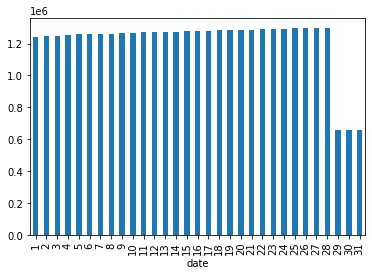

In [23]:
df['date'].groupby(df['date'].dt.day).count().plot(kind='bar')

Quantos registros temos por dia da semana?

Temos mais registros para Segunda, Terça e Quarta, provavelmente por conta do mês de Março de 2021 ser terminado em uma Quarta.

<AxesSubplot:xlabel='date'>

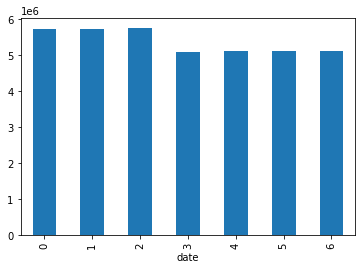

In [38]:
df['date'].groupby(df['date'].dt.weekday).count().plot(kind='bar')

#### sold_quantity
Para um SKU qualquer, quantas unidades foram vendidas ao todo?

In [24]:
sku_filtered = df[df['sku'] == 464801]
sku_filtered['sold_quantity'].sum()

15

E como ficam as vendas para cada um dos 60 dias?

<AxesSubplot:>

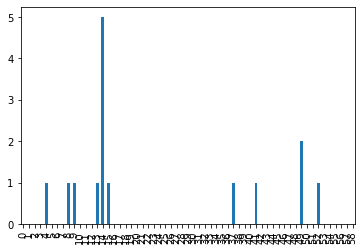

In [29]:
sku_filtered['sold_quantity'].plot(kind='bar')

<AxesSubplot:>

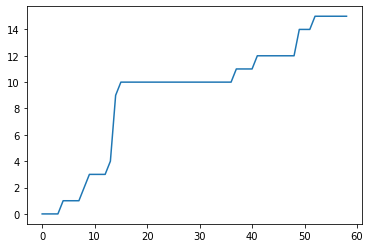

In [30]:
sku_filtered['sold_quantity'].cumsum().plot(kind='line')

Desconsiderando o SKU, quantas vendas são realizadas por dia?

Parece ter um efeito sazonal nas vendas.

<AxesSubplot:xlabel='date,date'>

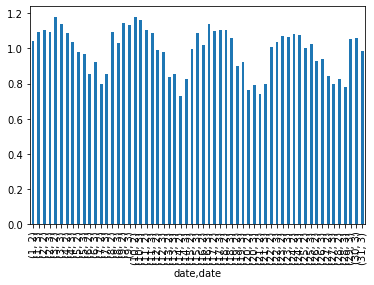

In [36]:
df.groupby([df['date'].dt.day, df['date'].dt.month]).mean()['sold_quantity'].plot(kind='bar')

Antes de investigar este efeito sazonal vamos remover a última semana de Março de 2021 pois ela se contra incompleta e pode enviesar as análises trazendo mais amostras para Segunda-Quarta.

In [39]:
without_last_week_of_march = df['date'] < '2021-03-29'

Acontecem mais vendas no início do mês do que ao final do mês?

Existe uma leve tendência decrescente ao longo do mês, porém não parece muito significativa.

<AxesSubplot:xlabel='date'>

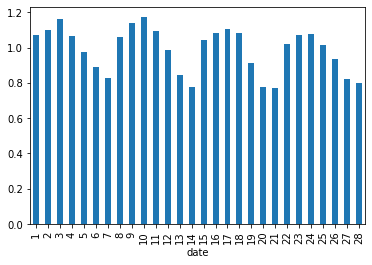

In [43]:
df[without_last_week_of_march].groupby(df[without_last_week_of_march]['date'].dt.day).mean()['sold_quantity'].plot(kind='bar')

Acontecem mais vendas nas 2 primeiras semanas do mês?

Mesmo efeito da última observação, existe uma variação aparente que pode indicar maior quantidade de vendas nas duas primeiras semanas do mês, porém esta variação está pequena e não vamos concluir nada a partir dela.

<AxesSubplot:xlabel='week'>

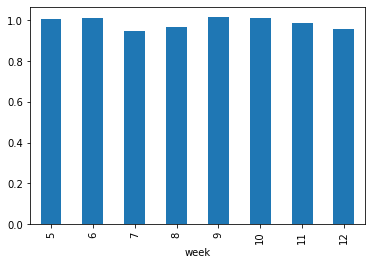

In [40]:
df[without_last_week_of_march].groupby(df[without_last_week_of_march]['date'].dt.isocalendar().week).mean()['sold_quantity'].plot(kind='bar')

Acontecem mais vendas nos finais de semana?

Como vemos nos gráficos anteriores, existe um efeito sazonal no nível dos dias de semana, este efeito indica que ocorrem mais vendas ao início da semana quando comparado com o final de semana. Sábado e Domingo são dias com notoriamente menos vendas, em média.

<AxesSubplot:xlabel='date'>

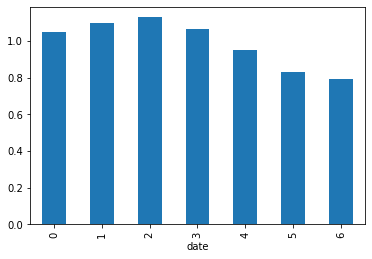

In [41]:
df[without_last_week_of_march].groupby(df[without_last_week_of_march]['date'].dt.weekday).mean()['sold_quantity'].plot(kind='bar')